In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import gc
import numpy as np
from torchsummary import summary
import time

# Base functions

## Dataloaders

In [2]:
class DataLoaderWrapFMINIST:
    def __init__(self, batch = 64):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, ), (0.5, ))
        ])

        self.train_data = datasets.FashionMNIST(
            root="./data",
            train=True,
            transform=transform,
            download=True
        )

        self.test_data = datasets.FashionMNIST(
            root="./data",
            train=False,
            transform=transform,
            download=True
        )

        self.train_loader = DataLoader(
            self.train_data,
            batch_size=batch,
            shuffle=True
            )

        self.test_loader = DataLoader(
            self.test_data,
            batch_size=batch,
            shuffle=False
            )

        self.class_names = self.train_data.classes


In [3]:
class DataLoaderWrapFMINISTr:
    def __init__(self, batch = 64):
        transform = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, ), (0.5, ))
        ])

        self.train_data = datasets.FashionMNIST(
            root="./data",
            train=True,
            transform=transform,
            download=True
        )

        self.test_data = datasets.FashionMNIST(
            root="./data",
            train=False,
            transform=transform,
            download=True
        )

        self.train_loader = DataLoader(
            self.train_data,
            batch_size=batch,
            shuffle=True
            )

        self.test_loader = DataLoader(
            self.test_data,
            batch_size=batch,
            shuffle=False
            )

        self.class_names = self.train_data.classes

## Trainer

In [4]:
class ModelUtils:
    def __init__(self, model, learning_rate=0.001):
        self.model = model

        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )

        self.model.to(self.device)

        self.criterion = nn.CrossEntropyLoss()

        self.optimizer = optim.Adam(
            self.model.parameters(),
            lr=learning_rate
        )

    def train(self, train_loader, test_loader, epochs):
        self.model.train()
        self.training_losses = []
        self.validation_losses = []

        for epoch in range(epochs):
            running_loss = 0.0
            for inputs, labels in train_loader:

                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                self.optimizer.zero_grad()

                outputs = self.model(inputs)

                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()

            avg_training_loss = running_loss / len(train_loader)
            self.training_losses.append(avg_training_loss)

            val_loss = 0.0

            self.model.eval()
            with torch.no_grad():
                for val_inputs, val_labels in test_loader:
                    val_inputs, val_labels = val_inputs.to(self.device), val_labels.to(self.device)
                    val_outputs = self.model(val_inputs)
                    val_loss += self.criterion(val_outputs, val_labels).item()

            avg_validation_loss = val_loss / len(test_loader)
            self.validation_losses.append(avg_validation_loss)
            self.model.train()

            print(f"Epoch {epoch + 1}, Training Loss: {avg_training_loss}, Validation Loss: {avg_validation_loss}")

    def evaluate(self, test_loader):
        self.model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []
        with torch.no_grad():
            for inputs, labels in test_loader:

                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                outputs = self.model(inputs)

                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

        accuracy = correct / total
        precision = precision_score(all_labels, all_predictions, average='weighted')
        recall = recall_score(all_labels, all_predictions, average='weighted')
        f1 = f1_score(all_labels, all_predictions, average='weighted')

        return accuracy, precision, recall, f1

    def predict(self, image):
        self.model.eval()
        image = image.to(self.device)
        with torch.no_grad():
            output = self.model(image.unsqueeze(0))
            _, predicted = torch.max(output.data, 1)
        return predicted.item()

    def save_model(self, file_path):
        torch.save(self.model.state_dict(), file_path)
        print(f"Model saved to {file_path}")

    def load_model(self, file_path):
        self.model.load_state_dict(torch.load(file_path))
        self.model.to(self.device)
        print(f"Model loaded from {file_path}")

    def remove_model(self):
        self.model.to('cpu')
        del self.model
        gc.collect()
        torch.cuda.empty_cache()


# Nets

## VGG

In [5]:
def vgg_block(num_convs, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

class VGG(nn.Module):
    def __init__(self, arch, num_classes):
        super(VGG, self).__init__()
        conv_blks = []

        for (num_convs, out_channels) in arch:
            conv_blks.append(vgg_block(num_convs, out_channels))

        self.net = nn.Sequential(
            *conv_blks,
            nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(num_classes)
        )

    def forward(self, x):
        return self.net(x)

## NIN

In [6]:
def nin_block(out_channels, kernel_size, strides, padding, conv=[[1,0],[1,0]]):
    layers = [nn.LazyConv2d(out_channels, kernel_size=kernel_size, stride=strides, padding=padding),nn.ReLU()]
    for conv1_size,conv1_padding in conv:
        layers.append(nn.LazyConv2d(out_channels, kernel_size=conv1_size,padding=conv1_padding))
        layers.append(nn.ReLU())
    return nn.Sequential(*layers)

class NIN(nn.Module):
    def __init__(self, arch, num_classes, fc_l = False):
        super(NIN, self).__init__()
        nin_blks = []

        for i in range(len(arch)-1):
            nin_blks.append(nin_block(*arch[i]))
            nin_blks.append(nn.MaxPool2d(3, stride=2))

        nin_blks.append(nn.Dropout(0.5))
        nin_blks.append(nin_block(*arch[-1]))

        if fc_l:
            nin_blks.append(nn.Flatten())
            nin_blks.append(nn.LazyLinear(num_classes))
        else:
            nin_blks.append(nn.AdaptiveAvgPool2d((1, 1)))
            nin_blks.append(nn.Flatten())

        self.net = nn.Sequential(*nin_blks)

    def forward(self, x):
        return self.net(x)

## GoogLeNet

### Base

In [16]:
class Inception(nn.Module):
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super().__init__(*kwargs)
        self.b1 = nn.Sequential(nn.LazyConv2d(c1, kernel_size=1),
                                nn.ReLU())
        self.b2 = nn.Sequential(nn.LazyConv2d(c2[0], kernel_size=1),
                                nn.ReLU(),
                                nn.LazyConv2d(c2[1], kernel_size=3, padding=1),
                                nn.ReLU())
        self.b3 = nn.Sequential(nn.LazyConv2d(c3[0], kernel_size=1),
                                nn.ReLU(),
                                nn.LazyConv2d(c3[1], kernel_size=5, padding=2),
                                nn.ReLU())
        self.b4 = nn.Sequential(nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
                                nn.LazyConv2d(c4, kernel_size=1),
                                nn.ReLU())

    def forward(self, x):
        o1 = self.b1(x)
        o2 = self.b2(x)
        o3 = self.b3(x)
        o4 = self.b4(x)
        return torch.cat((o1,o2,o3,o4),dim=1)


### BatchNorm

In [15]:
class NormInception(nn.Module):
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super().__init__(*kwargs)
        self.b1 = nn.Sequential(nn.LazyConv2d(c1, kernel_size=1),
                                nn.LazyBatchNorm2d(),
                                nn.ReLU())
        self.b2 = nn.Sequential(nn.LazyConv2d(c2[0], kernel_size=1),
                                nn.LazyBatchNorm2d(),
                                nn.ReLU(),
                                nn.LazyConv2d(c2[1], kernel_size=3, padding=1),
                                nn.LazyBatchNorm2d(),
                                nn.ReLU())
        self.b3 = nn.Sequential(nn.LazyConv2d(c3[0], kernel_size=1),
                                nn.LazyBatchNorm2d(),
                                nn.ReLU(),
                                nn.LazyConv2d(c3[1], kernel_size=5, padding=2),
                                nn.LazyBatchNorm2d(),
                                nn.ReLU())
        self.b4 = nn.Sequential(nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
                                nn.LazyBatchNorm2d(),
                                nn.LazyConv2d(c4, kernel_size=1),
                                nn.LazyBatchNorm2d(),
                                nn.ReLU())

    def forward(self, x):
        o1 = self.b1(x)
        o2 = self.b2(x)
        o3 = self.b3(x)
        o4 = self.b4(x)
        return torch.cat((o1,o2,o3,o4),dim=1)


### Residual connection

In [14]:
class ResInception(nn.Module):
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super().__init__(*kwargs)
        self.b1 = nn.Sequential(nn.LazyConv2d(c1, kernel_size=1),
                                nn.LazyBatchNorm2d(),
                                nn.ReLU())
        self.b2 = nn.Sequential(nn.LazyConv2d(c2[0], kernel_size=1),
                                nn.LazyBatchNorm2d(),
                                nn.ReLU(),
                                nn.LazyConv2d(c2[1], kernel_size=3, padding=1),
                                nn.LazyBatchNorm2d(),
                                nn.ReLU())
        self.b3 = nn.Sequential(nn.LazyConv2d(c3[0], kernel_size=1),
                                nn.LazyBatchNorm2d(),
                                nn.ReLU(),
                                nn.LazyConv2d(c3[1], kernel_size=5, padding=2),
                                nn.LazyBatchNorm2d(),
                                nn.ReLU())
        self.b4 = nn.Sequential(nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
                                nn.LazyConv2d(c4, kernel_size=1),
                                nn.LazyBatchNorm2d(),
                                nn.ReLU())
        self.conv1x1 = nn.LazyConv2d(c1 + c2[1] + c3[1] + c4, kernel_size=1)

    def forward(self, x):
        o1 = self.b1(x)
        o2 = self.b2(x)
        o3 = self.b3(x)
        o4 = self.b4(x)
        x = self.conv1x1(x)
        return torch.cat((o1, o2, o3, o4, x), dim=1)

###  Inception modules where each 5 × 5 convolution is replaced by two 3 × 3 convolution

In [13]:
class TwoThreeInception(nn.Module):
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super().__init__(*kwargs)

        if len(c3) == 2:
            c3 = (c3[0], c3[1], c3[1])

        self.b1 = nn.Sequential(nn.LazyConv2d(c1, kernel_size=1),
                                nn.ReLU())
        self.b2 = nn.Sequential(nn.LazyConv2d(c2[0], kernel_size=1),
                                nn.ReLU(),
                                nn.LazyConv2d(c2[1], kernel_size=3, padding=1),
                                nn.ReLU())
        self.b3 = nn.Sequential(nn.LazyConv2d(c3[0], kernel_size=1),
                                nn.ReLU(),
                                nn.LazyConv2d(c3[1], kernel_size=3, padding=1),
                                nn.ReLU(),
                                nn.LazyConv2d(c3[2], kernel_size=3, padding=1),
                                nn.ReLU())
        self.b4 = nn.Sequential(nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
                                nn.LazyConv2d(c4, kernel_size=1),
                                nn.ReLU())

    def forward(self, x):
        o1 = self.b1(x)
        o2 = self.b2(x)
        o3 = self.b3(x)
        o4 = self.b4(x)
        return torch.cat((o1,o2,o3,o4),dim=1)


### Asymmetric Inception

In [12]:
class AsymInception(nn.Module):
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super().__init__(*kwargs)

        if len(c2) == 2:
            c2 = (c2[0], c2[1], c2[1])
        if len(c3) == 2:
            c3 = (c3[0], c3[1], c3[1], c3[1], c3[1])

        self.b1 = nn.Sequential(nn.LazyConv2d(c1, kernel_size=1),
                                nn.ReLU())
        self.b2 = nn.Sequential(nn.LazyConv2d(c2[0], kernel_size=1),
                                nn.ReLU(),
                                nn.LazyConv2d(c2[1], kernel_size=(1,3), padding=(0,1)),
                                nn.ReLU(),
                                nn.LazyConv2d(c2[2], kernel_size=(3,1), padding=(1,0)),
                                nn.ReLU())
        self.b3 = nn.Sequential(nn.LazyConv2d(c3[0], kernel_size=1),
                                nn.ReLU(),
                                nn.LazyConv2d(c3[1], kernel_size=(1,3), padding=(0,1)),
                                nn.ReLU(),
                                nn.LazyConv2d(c3[2], kernel_size=(3,1), padding=(1,0)),
                                nn.ReLU(),
                                nn.LazyConv2d(c3[3], kernel_size=(1,3), padding=(0,1)),
                                nn.ReLU(),
                                nn.LazyConv2d(c3[4], kernel_size=(3,1), padding=(1,0)),
                                nn.ReLU())
        self.b4 = nn.Sequential(nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
                                nn.LazyConv2d(c4, kernel_size=1),
                                nn.ReLU())

    def forward(self, x):
        o1 = self.b1(x)
        o2 = self.b2(x)
        o3 = self.b3(x)
        o4 = self.b4(x)
        return torch.cat((o1,o2,o3,o4),dim=1)


### Model

In [11]:
class GoogleNet(nn.Module):
    def __init__(self, num_classes, inception_type=Inception):
        super(GoogleNet, self).__init__()
        self.inception_type = inception_type
        self.net = nn.Sequential(
            self.b1(),
            self.b2(),
            self.b3(),
            self.b4(),
            self.b5(),
            nn.LazyLinear(num_classes)
        )

    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

    def b2(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=1), nn.ReLU(),
            nn.LazyConv2d(192, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

    def b3(self):
        return nn.Sequential(
            self.inception_type(64, (96, 128), (16, 32), 32),
            self.inception_type(128, (128, 192), (32, 96), 64),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

    def b4(self):
        return nn.Sequential(
            self.inception_type(192, (96, 208), (16, 48), 64),
            self.inception_type(160, (112, 224), (24, 64), 64),
            self.inception_type(128, (128, 256), (24, 64), 64),
            self.inception_type(112, (144, 288), (32, 64), 64),
            self.inception_type(256, (160, 320), (32, 128), 128),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

    def b5(self):
        return nn.Sequential(
            self.inception_type(256, (160, 320), (32, 128), 128),
            self.inception_type(384, (192, 384), (48, 128), 128),
            nn.AdaptiveAvgPool2d((1,1)), nn.Flatten()
        )

    def forward(self, x):
        return self.net(x)

# 8.2 Networks Using Blocks (VGG)

## 1. 
Compared with AlexNet, VGG is much slower in terms of computation, and it also needs more GPU memory.

### 1.1 
Compare the number of parameters needed for AlexNet and VGG.

In [ ]:
data = DataLoaderWrapFMINIST(batch = 512)

arch=((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))
vgg = ModelUtils(
    VGG(arch = arch, num_classes = len(data.class_names)),
    learning_rate=0.001
    )

In [8]:
summary(vgg.model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
         MaxPool2d-3         [-1, 64, 112, 112]               0
            Conv2d-4        [-1, 128, 112, 112]          73,856
              ReLU-5        [-1, 128, 112, 112]               0
         MaxPool2d-6          [-1, 128, 56, 56]               0
            Conv2d-7          [-1, 256, 56, 56]         295,168
              ReLU-8          [-1, 256, 56, 56]               0
            Conv2d-9          [-1, 256, 56, 56]         590,080
             ReLU-10          [-1, 256, 56, 56]               0
        MaxPool2d-11          [-1, 256, 28, 28]               0
           Conv2d-12          [-1, 512, 28, 28]       1,180,160
             ReLU-13          [-1, 512, 28, 28]               0
           Conv2d-14          [-1, 512,

In [9]:
print(f"AlexNet conv: {3747200}")
print(f"AlexNet fc: {43040778}")

print(f"VGG conv: {9220480}")
print(f"VGG fc: {119586826}")

print(f"The VGG has {9220480 / 3747200} times more parameters in conv than AleNet")
print(f"The VGG has {119586826 / 43040778} times more parameters in fc than AleNet")

AlexNet conv: 3747200
AlexNet fc: 43040778
VGG conv: 9220480
VGG fc: 119586826
The VGG has 2.4606319385140907 times more parameters in conv than AleNet
The VGG has 2.778454097646655 times more parameters in fc than AleNet


### 1.2 
Compare the number of floating point operations used in the convolutional layers and in the fully connected layers.

In [10]:
print(f"AlexNet conv: {7485456384}")
print(f"AlexNet fc: {43040778}")

print(f"VGG conv: {962858112}")
print(f"VGG fc: {119586826}")

print(f"The VGG has {7485456384 / 962858112} times more floating point operations in conv than AleNet")
print(f"The VGG has {119586826 / 43040778} times more floating point operations in fc than AleNet")

AlexNet conv: 7485456384
AlexNet fc: 43040778
VGG conv: 962858112
VGG fc: 119586826
The VGG has 7.7742050367645446 times more floating point operations in conv than AleNet
The VGG has 2.778454097646655 times more floating point operations in fc than AleNet


### 1.3 
How could you reduce the computational cost created by the fully connected layers?


The following approaches can be used: PCA to reduce the dimension of the input data, use quantization, replace fully connected layers with convolutional layers with a 1x1 core, which will reduce the number of hyperparameters and redistribute weights

## 2. 
When displaying the dimensions associated with the various layers of the network, we only see the information associated with eight blocks (plus some auxiliary transforms), even though the network has 11 layers. Where did the remaining three layers go?

the last three convolutional layers contain 2 convolutions each

In [11]:
vgg.model

VGG(
  (net): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, 

## 3. 
Use Table 1 in the VGG paper (Simonyan and Zisserman, 2014) to construct other common models, such as VGG-16 or VGG-19.

In [12]:
arch16=((2, 64), (2, 128), (3, 256), (32, 512), (3, 512))
arch19=((2, 64), (2, 128), (4, 256), (4, 512), (4, 512))

vgg16 = ModelUtils(
    VGG(arch = arch16, num_classes = len(data.class_names)),
    learning_rate=0.001
    )

vgg19 = ModelUtils(
    VGG(arch = arch19, num_classes = len(data.class_names)),
    learning_rate=0.001
    )

In [13]:
summary(vgg16.model, (3, 224, 224))
vgg16.model

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

VGG(
  (net): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=

In [14]:
summary(vgg19.model, (3, 224, 224))
vgg19.model

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

VGG(
  (net): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU()
      (6): Conv2d(256, 256, kernel_size=(3, 3), stride

## 4. 
Upsampling the resolution in Fashion-MNIST eight-fold from 28×28 to 224×224 dimensions is very wasteful. Try modifying the network architecture and resolution conversion, e.g., to 56 or to 84 dimensions for its input instead. Can you do so without reducing the accuracy of the network? Consult the VGG paper (Simonyan and Zisserman, 2014) for ideas on adding more nonlinearities prior to downsampling.

In [15]:
data = DataLoaderWrapFMINIST(batch = 512)

arch_small = ((3, 128), (3, 256))
vgg_small = ModelUtils(
    VGG(arch = arch_small, num_classes = len(data.class_names)),
    learning_rate=0.001
    )

In [16]:
summary(vgg_small.model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 28, 28]           1,280
              ReLU-2          [-1, 128, 28, 28]               0
            Conv2d-3          [-1, 128, 28, 28]         147,584
              ReLU-4          [-1, 128, 28, 28]               0
            Conv2d-5          [-1, 128, 28, 28]         147,584
              ReLU-6          [-1, 128, 28, 28]               0
         MaxPool2d-7          [-1, 128, 14, 14]               0
            Conv2d-8          [-1, 256, 14, 14]         295,168
              ReLU-9          [-1, 256, 14, 14]               0
           Conv2d-10          [-1, 256, 14, 14]         590,080
             ReLU-11          [-1, 256, 14, 14]               0
           Conv2d-12          [-1, 256, 14, 14]         590,080
             ReLU-13          [-1, 256, 14, 14]               0
        MaxPool2d-14            [-1, 25

In [17]:
epochs=10
vgg_small.train(data.train_loader, data.test_loader, epochs=epochs)

Epoch 1, Training Loss: 0.8240412953546492, Validation Loss: 0.3659607842564583
Epoch 2, Training Loss: 0.31619235039767574, Validation Loss: 0.28647127747535706
Epoch 3, Training Loss: 0.25051629214973775, Validation Loss: 0.2560680009424686
Epoch 4, Training Loss: 0.21628339411848682, Validation Loss: 0.22885828614234924
Epoch 5, Training Loss: 0.18629517980803878, Validation Loss: 0.25891794040799143
Epoch 6, Training Loss: 0.17100370549044366, Validation Loss: 0.20697691440582275
Epoch 7, Training Loss: 0.1495608062941139, Validation Loss: 0.20395996198058128
Epoch 8, Training Loss: 0.134500090285378, Validation Loss: 0.2080501414835453
Epoch 9, Training Loss: 0.119157318467811, Validation Loss: 0.2158187821507454
Epoch 10, Training Loss: 0.104432724668818, Validation Loss: 0.24304116517305374


Accuracy: 0.9242
Precision: 0.9247763371781074
Recall: 0.9242
F1 Score: 0.923886273620218


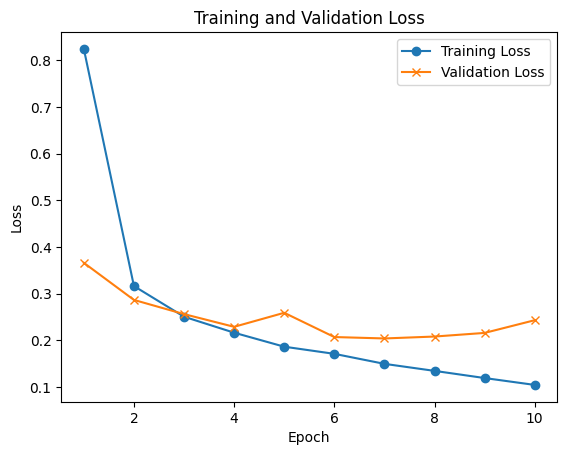

In [20]:
vgg_small_accuracy, vgg_small_precision, vgg_small_recall, vgg_small_f1 = vgg_small.evaluate(data.test_loader)

print(f"Accuracy: {vgg_small_accuracy}")
print(f"Precision: {vgg_small_precision}")
print(f"Recall: {vgg_small_recall}")
print(f"F1 Score: {vgg_small_f1}")

plt.plot(range(1, len(vgg_small.training_losses) + 1), vgg_small.training_losses, label='Training Loss', marker='o')
plt.plot(range(1, len(vgg_small.validation_losses) + 1), vgg_small.validation_losses, label='Validation Loss', marker='x')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

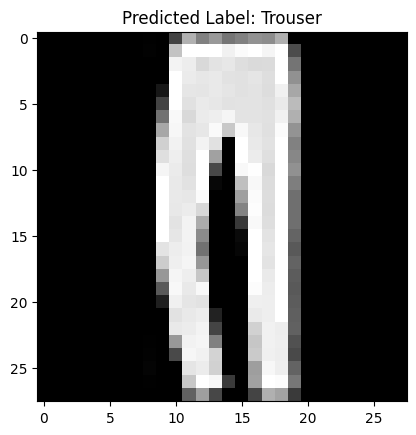

In [19]:
example_image, _ = next(iter(data.test_loader))
example_image = example_image[2]
predicted_label = vgg_small.predict(example_image)

plt.imshow((example_image.squeeze().numpy()), cmap="gray")
plt.title(f"Predicted Label: {data.class_names[predicted_label]}")
plt.show()

# 8.3. Network in Network (NiN)

In [26]:
data = DataLoaderWrapFMINISTr(batch = 512)

arch = ((96,11,4,0),(256,5,1,2),(384,3,1,1),(10,3,1,1))

nin = ModelUtils(
    NIN(arch = arch, num_classes = len(data.class_names), fc_l = False),
    learning_rate=0.001
    )
nin_fc = ModelUtils(
    NIN(arch = arch, num_classes = len(data.class_names), fc_l = True),
    learning_rate=0.001
    )

arch_1_1 = ((96,11,4,0,[[1,0]]),(256,5,1,2,[[1,0]]),(384,3,1,1,[[1,0]]),(10,3,1,1,[[1,0]]))
nin_1_1 = ModelUtils(
    NIN(arch = arch_1_1, num_classes = len(data.class_names), fc_l = False),
    learning_rate=0.001
    )

arch_3_1 = ((96,11,4,0,[[1,0],[1,0],[1,0]]),(256,5,1,2,[[1,0],[1,0],[1,0]]),(384,3,1,1,[[1,0],[1,0],[1,0]]),(10,3,1,1,[[1,0],[1,0],[1,0]]))
nin_3_1 = ModelUtils(
    NIN(arch = arch_3_1, num_classes = len(data.class_names), fc_l = False),
    learning_rate=0.001
    )

arch_3 = ((96,11,4,0,[[3,1],[3,1]]),(256,5,1,2,[[3,1],[3,1]]),(384,3,1,1,[[3,1],[3,1]]),(10,3,1,1,[[3,1],[3,1]]))
nin_3 = ModelUtils(
    NIN(arch = arch_3, num_classes = len(data.class_names), fc_l = False),
    learning_rate=0.001
    )

In [27]:
epochs=20

start_time = time.time()
nin.train(data.train_loader, data.test_loader, epochs=epochs)
end_time = time.time()
nin_training_time = end_time - start_time

start_time = time.time()
nin_fc.train(data.train_loader, data.test_loader, epochs=epochs)
end_time = time.time()
nin_fc_training_time = end_time - start_time

start_time = time.time()
nin_3.train(data.train_loader, data.test_loader, epochs=epochs)
end_time = time.time()
nin_3_training_time = end_time - start_time

start_time = time.time()
nin_1_1.train(data.train_loader, data.test_loader, epochs=epochs)
end_time = time.time()
nin_1_1_training_time = end_time - start_time

start_time = time.time()
nin_3_1.train(data.train_loader, data.test_loader, epochs=epochs)
end_time = time.time()
nin_3_1_fc_training_time = end_time - start_time


Epoch 1, Training Loss: 2.0800760044889937, Validation Loss: 1.648329347372055
Epoch 2, Training Loss: 1.1921743381831607, Validation Loss: 0.918365615606308
Epoch 3, Training Loss: 0.8260073550676895, Validation Loss: 0.9038094729185104
Epoch 4, Training Loss: 0.7606311763747263, Validation Loss: 0.7111395627260209
Epoch 5, Training Loss: 0.6626027913416846, Validation Loss: 0.6455960065126419
Epoch 6, Training Loss: 0.6222826085858426, Validation Loss: 0.6142073750495911
Epoch 7, Training Loss: 0.6166645960282471, Validation Loss: 0.6243149131536484
Epoch 8, Training Loss: 0.5743160651902021, Validation Loss: 0.568404783308506
Epoch 9, Training Loss: 0.5499036216129691, Validation Loss: 0.5582410886883735
Epoch 10, Training Loss: 0.5469814210625018, Validation Loss: 0.55900359749794
Epoch 11, Training Loss: 0.52024181818558, Validation Loss: 0.5293588951230049
Epoch 12, Training Loss: 0.5063173258203572, Validation Loss: 0.5294746354222297
Epoch 13, Training Loss: 0.5027934095617068,

In [29]:
print(f"NiN training time: {nin_training_time:.2f} seconds")
print(f"NiN_FC training time: {nin_fc_training_time:.2f} seconds")
print(f"NiN_3 training time: {nin_3_training_time:.2f} seconds")
print(f"NiN_1_1 training time: {nin_1_1_training_time:.2f} seconds")
print(f"NiN_3_1 training time: {nin_3_1_fc_training_time:.2f} seconds")

NiN training time: 1744.86 seconds
NiN_FC training time: 1766.04 seconds
NiN_3 training time: 2463.00 seconds
NiN_1_1 training time: 1615.06 seconds
NiN_3_1 training time: 2000.41 seconds


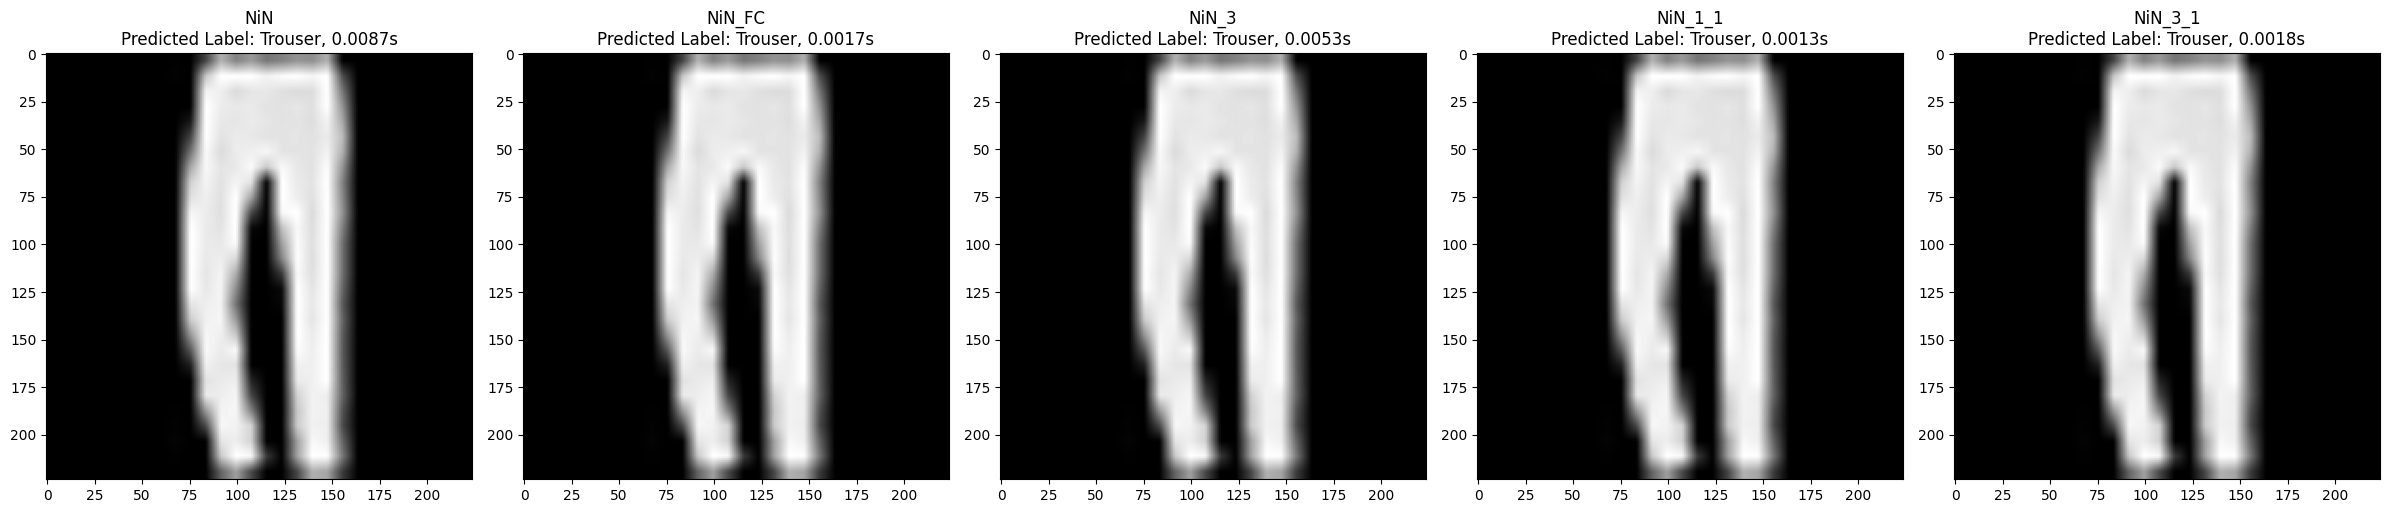

In [32]:
example_image, _ = next(iter(data.test_loader))
example_image = example_image[2]

start_time = time.time()
predicted_label_nin = nin.predict(example_image)
end_time = time.time()
nin_inference_time = end_time - start_time

start_time = time.time()
predicted_label_nin_fc = nin_fc.predict(example_image)
end_time = time.time()
nin_fc_inference_time = end_time - start_time

start_time = time.time()
predicted_label_nin_3 = nin_3.predict(example_image)
end_time = time.time()
nin_3_inference_time = end_time - start_time

start_time = time.time()
predicted_label_nin_1_1 = nin_1_1.predict(example_image)
end_time = time.time()
nin_1_1_inference_time = end_time - start_time

start_time = time.time()
predicted_label_nin_3_1 = nin_3_1.predict(example_image)
end_time = time.time()
nin_3_1_inference_time = end_time - start_time

fig, axs = plt.subplots(1, 5, figsize=(24, 6))

axs[0].imshow((example_image.squeeze().numpy()), cmap="gray")
axs[0].set_title(f"NiN\nPredicted Label: {data.class_names[predicted_label_nin]}, {nin_inference_time:.4f}s")

axs[1].imshow((example_image.squeeze().numpy()), cmap="gray")
axs[1].set_title(f"NiN_FC\nPredicted Label: {data.class_names[predicted_label_nin_fc]}, {nin_fc_inference_time:.4f}s")

axs[2].imshow((example_image.squeeze().numpy()), cmap="gray")
axs[2].set_title(f"NiN_3\nPredicted Label: {data.class_names[predicted_label_nin_3]}, {nin_3_inference_time:.4f}s")

axs[3].imshow((example_image.squeeze().numpy()), cmap="gray")
axs[3].set_title(f"NiN_1_1\nPredicted Label: {data.class_names[predicted_label_nin_1_1]}, {nin_1_1_inference_time:.4f}s")

axs[4].imshow((example_image.squeeze().numpy()), cmap="gray")
axs[4].set_title(f"NiN_3_1\nPredicted Label: {data.class_names[predicted_label_nin_3_1]}, {nin_3_1_inference_time:.4f}s")

plt.tight_layout()
plt.show()

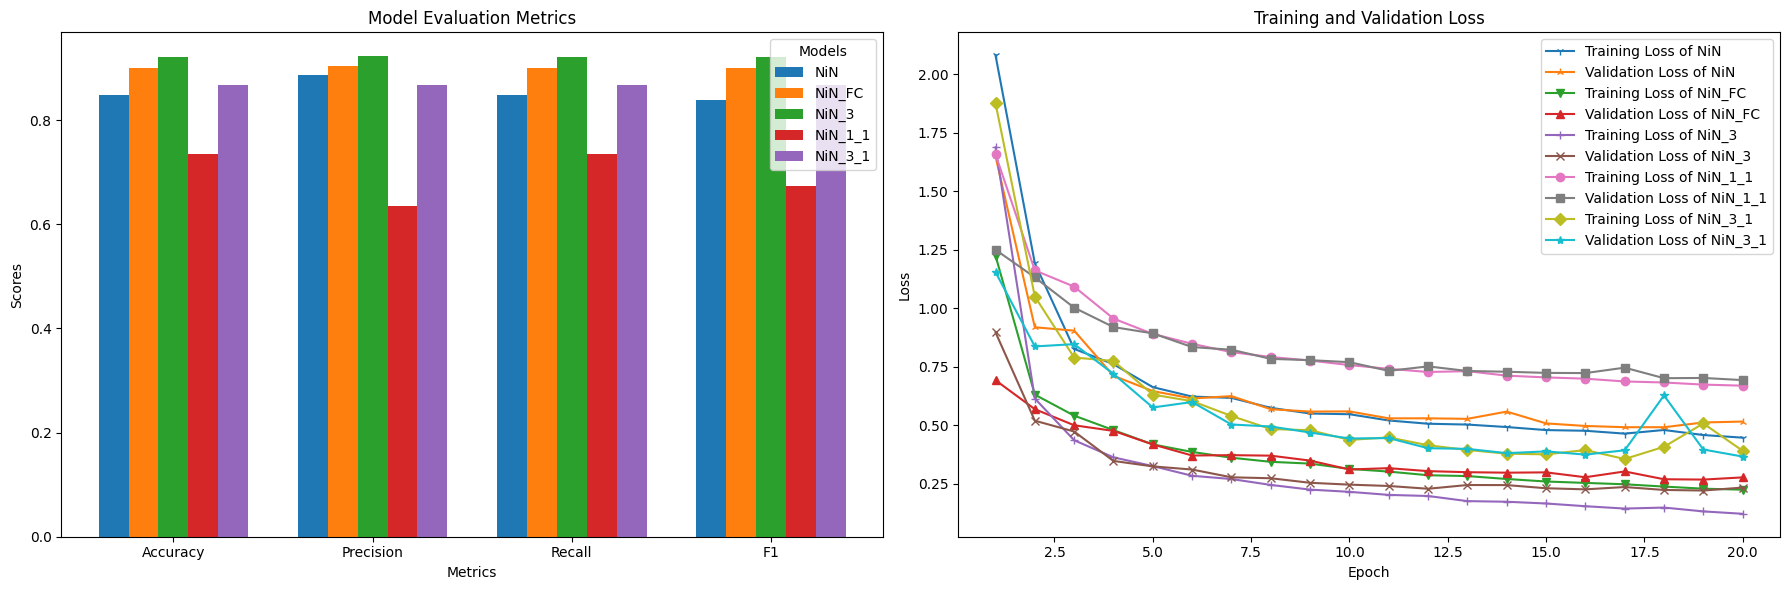

In [ ]:
nin_accuracy, nin_precision, nin_recall, nin_f1 = nin.evaluate(data.test_loader)
nin_fc_accuracy, nin_fc_precision, nin_fc_recall, nin_fc_f1 = nin_fc.evaluate(data.test_loader)
nin_3_accuracy, nin_3_precision, nin_3_recall, nin_3_f1 = nin_3.evaluate(data.test_loader)
nin_1_1_accuracy, nin_1_1_precision, nin_1_1_recall, nin_1_1_f1 = nin_1_1.evaluate(data.test_loader)
nin_3_1_accuracy, nin_3_1_precision, nin_3_1_recall, nin_3_1_f1 = nin_3_1.evaluate(data.test_loader)

models = ['NiN', 'NiN_FC', 'NiN_3', 'NiN_1_1', 'NiN_3_1']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']

data_of_models = {
    'NiN': [nin_accuracy, nin_precision, nin_recall, nin_f1],
    'NiN_FC': [nin_fc_accuracy, nin_fc_precision, nin_fc_recall, nin_fc_f1],
    'NiN_3': [nin_3_accuracy, nin_3_precision, nin_3_recall, nin_3_f1],
    'NiN_1_1': [nin_1_1_accuracy, nin_1_1_precision, nin_1_1_recall, nin_1_1_f1],
    'NiN_3_1': [nin_3_1_accuracy, nin_3_1_precision, nin_3_1_recall, nin_3_1_f1]
}

x = np.arange(len(metrics))
width = 0.15

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

for i, model in enumerate(models):
    offset = i * width
    ax1.bar(x + offset, data_of_models[model], width, label=model, color=colors[i])

ax1.set_xlabel('Metrics')
ax1.set_ylabel('Scores')
ax1.set_title('Model Evaluation Metrics')
ax1.set_xticks(x + width * 2)
ax1.set_xticklabels(metrics)
ax1.legend(title='Models')

ax2.plot(range(1, len(nin.training_losses) + 1), nin.training_losses, label='Training Loss of NiN', marker='1')
ax2.plot(range(1, len(nin.validation_losses) + 1), nin.validation_losses, label='Validation Loss of NiN', marker='2')
ax2.plot(range(1, len(nin_fc.training_losses) + 1), nin_fc.training_losses, label='Training Loss of NiN_FC', marker='v')
ax2.plot(range(1, len(nin_fc.validation_losses) + 1), nin_fc.validation_losses, label='Validation Loss of NiN_FC', marker='^')
ax2.plot(range(1, len(nin_3.training_losses) + 1), nin_3.training_losses, label='Training Loss of NiN_3', marker='+')
ax2.plot(range(1, len(nin_3.validation_losses) + 1), nin_3.validation_losses, label='Validation Loss of NiN_3', marker='x')
ax2.plot(range(1, len(nin_1_1.training_losses) + 1), nin_1_1.training_losses, label='Training Loss of NiN_1_1', marker='o')
ax2.plot(range(1, len(nin_1_1.validation_losses) + 1), nin_1_1.validation_losses, label='Validation Loss of NiN_1_1', marker='s')
ax2.plot(range(1, len(nin_3_1.training_losses) + 1), nin_3_1.training_losses, label='Training Loss of NiN_3_1', marker='D')
ax2.plot(range(1, len(nin_3_1.validation_losses) + 1), nin_3_1.validation_losses, label='Validation Loss of NiN_3_1', marker='*')

ax2.set_title("Training and Validation Loss")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.legend()

plt.tight_layout()
plt.show()

## 1. 
Why are there two 1x1 convolutional layers per NiN block? Increase their number to three. Reduce their number to one. What changes?

Two 1x1 convolutional layers per NiN block:
There is more non-linearity and opportunities for feature conversion, which leads to increased accuracy, but reduces performance.

Three 1x1 convolutional layers per NiN block:
There is even more non-linearity and opportunities for feature transformation, which leads to increased accuracy and makes it possible to get more information from the image, but it further reduces productivity, and the increased number of parameters is prone to overfitting.

One 1x1 convolutional layer per NiN block:
There are fewer computational costs, faster learning and inference, but less accuracy and limited interaction in the feature space.

## 2. 
What changes if you replace the 1x1 convolutions by 3x3 convolutions?

Estimate based on plots and time estimates.

## 3. 
What happens if you replace the global average pooling by a fully connected layer (speed, accuracy, number of parameters)?

Estimate based on plots and time estimates.

## 4.
Calculate the resource usage for NiN.

### 4.1
What is the number of parameters?

2,015,398

### 4.2
What is the amount of computation?

### 4.3
What is the amount of memory needed during training?

### 4.4
What is the amount of memory needed during prediction?

## 5. 
What are possible problems with reducing the 384x5x5 representation to a 10x5x5 representation in one step?

Reducing the number of channels may limit the model's ability to study high-level features.  Each channel contains specific features, their reduction may lead to loss of the ability to distinguish classes. Decreased generalization ability

## 6. 
Use the structural design decisions in VGG that led to VGG-11, VGG-16, and VGG-19 to design a family of NiN-like networks.

In [56]:
summary(nin.model, (1, 224, 224))
nin.model

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 54, 54]          11,712
              ReLU-2           [-1, 96, 54, 54]               0
            Conv2d-3           [-1, 96, 54, 54]           9,312
              ReLU-4           [-1, 96, 54, 54]               0
            Conv2d-5           [-1, 96, 54, 54]           9,312
              ReLU-6           [-1, 96, 54, 54]               0
         MaxPool2d-7           [-1, 96, 26, 26]               0
            Conv2d-8          [-1, 256, 26, 26]         614,656
              ReLU-9          [-1, 256, 26, 26]               0
           Conv2d-10          [-1, 256, 26, 26]          65,792
             ReLU-11          [-1, 256, 26, 26]               0
           Conv2d-12          [-1, 256, 26, 26]          65,792
             ReLU-13          [-1, 256, 26, 26]               0
        MaxPool2d-14          [-1, 256,

NIN(
  (net): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4))
      (1): ReLU()
      (2): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
      (3): ReLU()
      (4): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
      (5): ReLU()
    )
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Sequential(
      (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
      (3): ReLU()
      (4): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
      (5): ReLU()
    )
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1))
      (3): ReLU()
      (4): Conv2d(384, 384, kernel_size=(1, 1), stride=(1

# 8.4 Multi-Branch Networks (GoogLeNet)

In [ ]:
data = DataLoaderWrapFMINISTr(batch = 512)
epochs = 20


In [18]:
googlenet = ModelUtils(
    GoogleNet(num_classes=len(data.class_names), inception_type=Inception),
    learning_rate=0.001
)

start_time = time.time()
googlenet.train(data.train_loader, data.test_loader, epochs=epochs)
end_time = time.time()
inception_training_time = end_time - start_time

inception_accuracy, inception_precision, inception_recall, inception_f1 = googlenet.evaluate(data.test_loader)

inception_model_training_losses = googlenet.training_losses
inception_model_validation_losses = googlenet.validation_losses


Epoch 1, Training Loss: 1.9178338222584481, Validation Loss: 1.4761336386203765
Epoch 2, Training Loss: 1.0304832968671442, Validation Loss: 0.6882134675979614
Epoch 3, Training Loss: 0.5381042644128962, Validation Loss: 0.46608382612466814
Epoch 4, Training Loss: 0.4039697924912986, Validation Loss: 0.4127298444509506
Epoch 5, Training Loss: 0.33602951618574434, Validation Loss: 0.3234434224665165
Epoch 6, Training Loss: 0.2974295853558233, Validation Loss: 0.30088760033249856
Epoch 7, Training Loss: 0.2717325196175252, Validation Loss: 0.3315405875444412
Epoch 8, Training Loss: 0.2511175306419195, Validation Loss: 0.2742955431342125
Epoch 9, Training Loss: 0.23196810168229928, Validation Loss: 0.2997857563197613
Epoch 10, Training Loss: 0.21205935841899806, Validation Loss: 0.2467838078737259
Epoch 11, Training Loss: 0.20195140260255942, Validation Loss: 0.2732613518834114
Epoch 12, Training Loss: 0.1962420454848621, Validation Loss: 0.2788196176290512
Epoch 13, Training Loss: 0.1822

In [20]:
googlenet = ModelUtils(
    GoogleNet(num_classes=len(data.class_names), inception_type=NormInception),
    learning_rate=0.001
)

start_time = time.time()
googlenet.train(data.train_loader, data.test_loader, epochs=epochs)
end_time = time.time()
norm_inception_training_time = end_time - start_time

norm_inception_accuracy, norm_inception_precision, norm_inception_recall, norm_inception_f1 = googlenet.evaluate(data.test_loader)

norm_inception_model_training_losses = googlenet.training_losses
norm_inception_model_validation_losses = googlenet.validation_losses


Epoch 1, Training Loss: 0.47217259884385737, Validation Loss: 0.3786426573991776
Epoch 2, Training Loss: 0.2914562863060984, Validation Loss: 0.4986045092344284
Epoch 3, Training Loss: 0.25269237653178683, Validation Loss: 0.4096407502889633
Epoch 4, Training Loss: 0.22192850948895437, Validation Loss: 0.32533163353800776
Epoch 5, Training Loss: 0.19842137320566985, Validation Loss: 0.26463380828499794
Epoch 6, Training Loss: 0.1821721044005984, Validation Loss: 0.3025414578616619
Epoch 7, Training Loss: 0.1679765638911118, Validation Loss: 0.29972519278526305
Epoch 8, Training Loss: 0.15497593625874842, Validation Loss: 0.3380194023251534
Epoch 9, Training Loss: 0.14224390660302114, Validation Loss: 0.3020554356276989
Epoch 10, Training Loss: 0.12867336492922346, Validation Loss: 0.23563503921031953
Epoch 11, Training Loss: 0.12139460602301662, Validation Loss: 0.2841437220573425
Epoch 12, Training Loss: 0.114511818514537, Validation Loss: 0.2496272161602974
Epoch 13, Training Loss: 0

In [22]:
googlenet = ModelUtils(
    GoogleNet(num_classes=len(data.class_names), inception_type=ResInception),
    learning_rate=0.001
)

start_time = time.time()
googlenet.train(data.train_loader, data.test_loader, epochs=epochs)
end_time = time.time()
res_inception_training_time = end_time - start_time

res_inception_accuracy, res_inception_precision, res_inception_recall, res_inception_f1 = googlenet.evaluate(data.test_loader)

res_inception_model_training_losses = googlenet.training_losses
res_inception_model_validation_losses = googlenet.validation_losses


Epoch 1, Training Loss: 0.5963056797193269, Validation Loss: 1.0483845680952073
Epoch 2, Training Loss: 0.3131914623713089, Validation Loss: 0.4454463183879852
Epoch 3, Training Loss: 0.2578607952948344, Validation Loss: 0.42950960993766785
Epoch 4, Training Loss: 0.23122626025292833, Validation Loss: 0.5365725263953209
Epoch 5, Training Loss: 0.2060737873790628, Validation Loss: 0.3952689588069916
Epoch 6, Training Loss: 0.1854475060383142, Validation Loss: 0.391931988298893
Epoch 7, Training Loss: 0.17566695916703193, Validation Loss: 0.36326315477490423
Epoch 8, Training Loss: 0.1540661385377585, Validation Loss: 0.35523178726434707
Epoch 9, Training Loss: 0.144425197772808, Validation Loss: 0.33552824705839157
Epoch 10, Training Loss: 0.13592471561189426, Validation Loss: 0.33443867787718773
Epoch 11, Training Loss: 0.1303128247796479, Validation Loss: 0.35869634747505186
Epoch 12, Training Loss: 0.11841019571332609, Validation Loss: 0.3421470195055008
Epoch 13, Training Loss: 0.10

In [24]:
googlenet = ModelUtils(
    GoogleNet(num_classes=len(data.class_names), inception_type=TwoThreeInception),
    learning_rate=0.001
)

start_time = time.time()
googlenet.train(data.train_loader, data.test_loader, epochs=epochs)
end_time = time.time()
two_three_inception_training_time = end_time - start_time

two_three_inception_accuracy, two_three_inception_precision, two_three_inception_recall, two_three_inception_f1 = googlenet.evaluate(data.test_loader)

two_three_inception_model_training_losses = googlenet.training_losses
two_three_inception_model_validation_losses = googlenet.validation_losses


Epoch 1, Training Loss: 2.391314689385689, Validation Loss: 2.2914837121963503
Epoch 2, Training Loss: 1.8910867086911605, Validation Loss: 1.3437013685703278
Epoch 3, Training Loss: 0.9709684075945515, Validation Loss: 1.0426461815834045
Epoch 4, Training Loss: 0.6993697917057295, Validation Loss: 0.6281793981790542
Epoch 5, Training Loss: 0.5487942160186121, Validation Loss: 0.5312532722949982
Epoch 6, Training Loss: 0.43885044955601127, Validation Loss: 0.4605994626879692
Epoch 7, Training Loss: 0.39235057366096365, Validation Loss: 0.43564254939556124
Epoch 8, Training Loss: 0.3580945341263787, Validation Loss: 0.3686934694647789
Epoch 9, Training Loss: 0.33020492264274826, Validation Loss: 0.34430489093065264
Epoch 10, Training Loss: 0.31014252933910336, Validation Loss: 0.3397974967956543
Epoch 11, Training Loss: 0.29932054864653085, Validation Loss: 0.3272973746061325
Epoch 12, Training Loss: 0.2762423449401128, Validation Loss: 0.2982136018574238
Epoch 13, Training Loss: 0.2613

In [26]:
googlenet = ModelUtils(
    GoogleNet(num_classes=len(data.class_names), inception_type=AsymInception),
    learning_rate=0.001
)

start_time = time.time()
googlenet.train(data.train_loader, data.test_loader, epochs=epochs)
end_time = time.time()
asym_inception_training_time = end_time - start_time

asym_inception_accuracy, asym_inception_precision, asym_inception_recall, asym_inception_f1 = googlenet.evaluate(data.test_loader)

asym_inception_model_training_losses = googlenet.training_losses
asym_inception_model_validation_losses = googlenet.validation_losses


Epoch 1, Training Loss: 2.348762819322489, Validation Loss: 2.1758441805839537
Epoch 2, Training Loss: 1.3693777039899664, Validation Loss: 0.7304746866226196
Epoch 3, Training Loss: 0.5986743541592259, Validation Loss: 0.5971810072660446
Epoch 4, Training Loss: 0.46807168929253595, Validation Loss: 0.49592377841472624
Epoch 5, Training Loss: 0.41176346853628, Validation Loss: 0.40888901650905607
Epoch 6, Training Loss: 0.3673832270048432, Validation Loss: 0.41507946252822875
Epoch 7, Training Loss: 0.3524413028005826, Validation Loss: 0.35447600930929185
Epoch 8, Training Loss: 0.3292645877700741, Validation Loss: 0.3726538807153702
Epoch 9, Training Loss: 0.3128017663198002, Validation Loss: 0.3399121522903442
Epoch 10, Training Loss: 0.29093011986401124, Validation Loss: 0.34510095715522765
Epoch 11, Training Loss: 0.2777905276645038, Validation Loss: 0.3223882749676704
Epoch 12, Training Loss: 0.268998011188992, Validation Loss: 0.30731829181313514
Epoch 13, Training Loss: 0.256218

In [28]:
print(f"Inception training time: {inception_training_time:.2f} seconds")
print(f"NormInception training time: {norm_inception_training_time:.2f} seconds")
print(f"ResInception training time: {res_inception_training_time:.2f} seconds")
print(f"TwoThreeInception training time: {two_three_inception_training_time:.2f} seconds")
print(f"AsymInception training time: {asym_inception_training_time:.2f} seconds")


Inception training time: 754.47 seconds
NormInception training time: 771.38 seconds
ResInception training time: 1192.08 seconds
TwoThreeInception training time: 731.64 seconds
AsymInception training time: 861.68 seconds


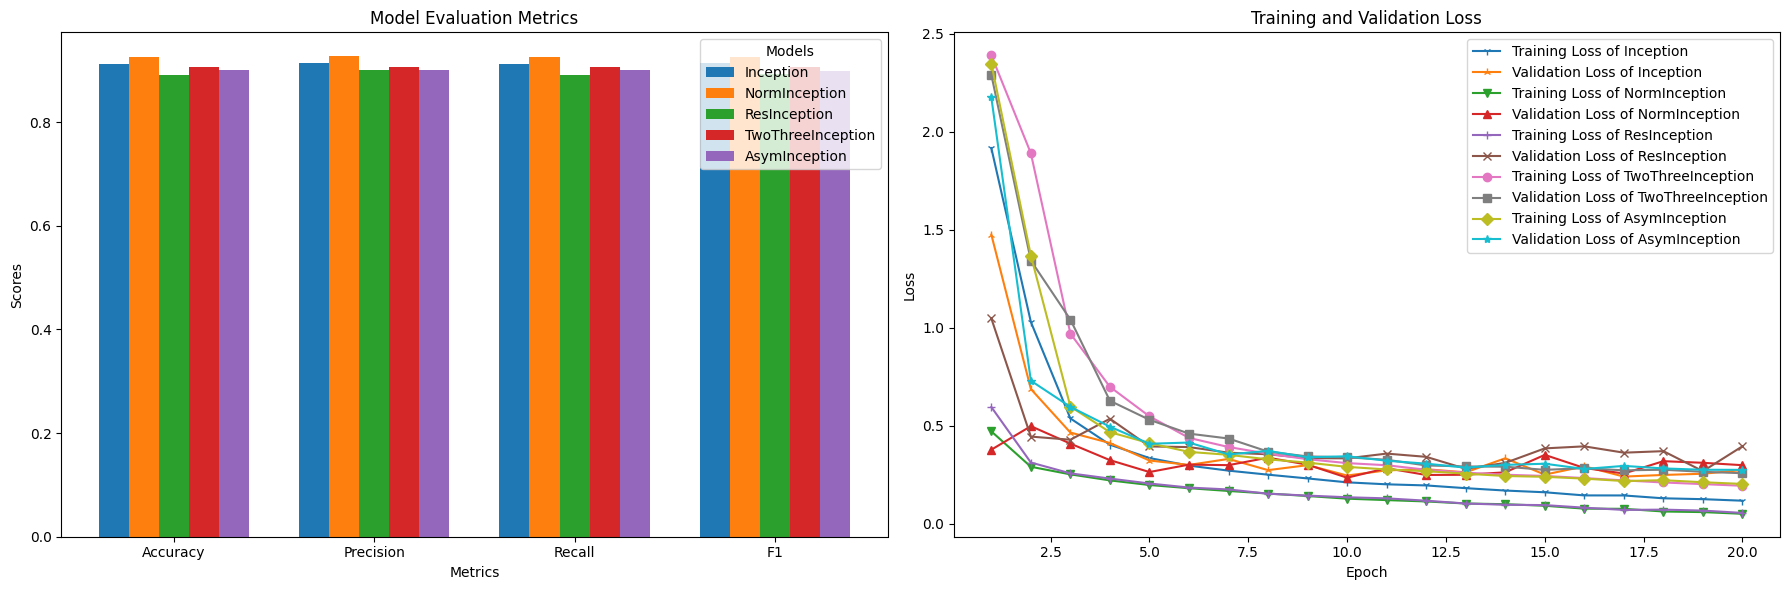

In [29]:
import numpy as np
import matplotlib.pyplot as plt

models = ['Inception', 'NormInception', 'ResInception', 'TwoThreeInception', 'AsymInception']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']

data_of_models = {
    'Inception': [inception_accuracy, inception_precision, inception_recall, inception_f1],
    'NormInception': [norm_inception_accuracy, norm_inception_precision, norm_inception_recall, norm_inception_f1],
    'ResInception': [res_inception_accuracy, res_inception_precision, res_inception_recall, res_inception_f1],
    'TwoThreeInception': [two_three_inception_accuracy, two_three_inception_precision, two_three_inception_recall, two_three_inception_f1],
    'AsymInception': [asym_inception_accuracy, asym_inception_precision, asym_inception_recall, asym_inception_f1]
}

x = np.arange(len(metrics))
width = 0.15

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

for i, model in enumerate(models):
    offset = i * width
    ax1.bar(x + offset, data_of_models[model], width, label=model, color=colors[i])

ax1.set_xlabel('Metrics')
ax1.set_ylabel('Scores')
ax1.set_title('Model Evaluation Metrics')
ax1.set_xticks(x + width * 2)
ax1.set_xticklabels(metrics)
ax1.legend(title='Models')

ax2.plot(range(1, len(inception_model_training_losses) + 1), inception_model_training_losses, label='Training Loss of Inception', marker='1')
ax2.plot(range(1, len(inception_model_validation_losses) + 1), inception_model_validation_losses, label='Validation Loss of Inception', marker='2')
ax2.plot(range(1, len(norm_inception_model_training_losses) + 1), norm_inception_model_training_losses, label='Training Loss of NormInception', marker='v')
ax2.plot(range(1, len(norm_inception_model_validation_losses) + 1), norm_inception_model_validation_losses, label='Validation Loss of NormInception', marker='^')
ax2.plot(range(1, len(res_inception_model_training_losses) + 1), res_inception_model_training_losses, label='Training Loss of ResInception', marker='+')
ax2.plot(range(1, len(res_inception_model_validation_losses) + 1), res_inception_model_validation_losses, label='Validation Loss of ResInception', marker='x')
ax2.plot(range(1, len(two_three_inception_model_training_losses) + 1), two_three_inception_model_training_losses, label='Training Loss of TwoThreeInception', marker='o')
ax2.plot(range(1, len(two_three_inception_model_validation_losses) + 1), two_three_inception_model_validation_losses, label='Validation Loss of TwoThreeInception', marker='s')
ax2.plot(range(1, len(asym_inception_model_training_losses) + 1), asym_inception_model_training_losses, label='Training Loss of AsymInception', marker='D')
ax2.plot(range(1, len(asym_inception_model_validation_losses) + 1), asym_inception_model_validation_losses, label='Validation Loss of AsymInception', marker='*')

ax2.set_title("Training and Validation Loss")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.legend()

plt.tight_layout()
plt.show()


## 1.
GoogLeNet was so successful that it went through a number of iterations, progressively improving speed and accuracy. Try to implement and run some of them. They include the following:

## 2. 
What is the minimum image size needed for GoogLeNet to work?

GoogLe Net compresses the image twice 5 times, which means 2^5 = 32

In [30]:
summary(googlenet.model, (1, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           3,200
              ReLU-2           [-1, 64, 16, 16]               0
         MaxPool2d-3             [-1, 64, 8, 8]               0
            Conv2d-4             [-1, 64, 8, 8]           4,160
              ReLU-5             [-1, 64, 8, 8]               0
            Conv2d-6            [-1, 192, 8, 8]         110,784
              ReLU-7            [-1, 192, 8, 8]               0
         MaxPool2d-8            [-1, 192, 4, 4]               0
            Conv2d-9             [-1, 64, 4, 4]          12,352
             ReLU-10             [-1, 64, 4, 4]               0
           Conv2d-11             [-1, 96, 4, 4]          18,528
             ReLU-12             [-1, 96, 4, 4]               0
           Conv2d-13            [-1, 128, 4, 4]          36,992
             ReLU-14            [-1, 12

## 3. 
Can you design a variant of GoogLeNet that works on Fashion-MNIST’s native resolution of 28x28 pixels? How would you need to change the stem, the body, and the head of the network, if anything at all?

To work with 28x28 images, I will remove the MaxPool2d in b1

## 4. 
Compare the model parameter sizes of AlexNet, VGG, NiN, and GoogLeNet. How do the latter two network architectures significantly reduce the model parameter size?

GoogLeNet - 5983802

VGG - 128807306	

NiN - 2015398

AlexNet - 46787978

NiN and GoogLeNet significantly reduce the number of parameters by using 1x1 convolution and the inception module, respectively. These methods allow models to efficiently recognize objects while controlling the number of parameters. 1x1 convolutions in both models reduce the dimension of feature maps and, consequently, the number of parameters in subsequent layers.